In [76]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from django.db.models import Count, Avg, F
import math

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *





In [77]:

p = Project.objects.get(title="NETs")
pdocs = Doc.objects.filter(query__project=p)

trdocs = set(list(pdocs.filter(docownership__relevant=1).values_list('UT',flat=True)))

ttdocs = set(list(Doc.objects.filter(technology__project=p).values_list('UT',flat=True)))

In [78]:
print(len(trdocs))
print(len(ttdocs))

allreldocs =  Doc.objects.filter(
    UT__in=trdocs.union(ttdocs)
)

print(allreldocs.count())


2015
269
2208


In [79]:
doc_dict = []

ts = Technology.objects.filter(
    project=p
).exclude(
    name__in=['Bioenergy','ethics & Morals']
)
pys = list(range(1990,2017))
for t in ts:
    for py in pys:
        ydocs = allreldocs.filter(PY=py)
        trdocs = set(list(ydocs.filter(
            query__technology=t,docownership__relevant=1,docownership__query__technology=t
        ).values_list('UT',flat=True)))
        ttdocs = set(list(ydocs.filter(
            technology=t
        ).values_list('UT',flat=True)))
        tdocs = Doc.objects.filter(
            UT__in=trdocs.union(ttdocs)
        )
        d = {
            'Technology': t.name,
            'PY': py,
            'n': tdocs.count()
        }
        doc_dict.append(d)

In [80]:
df = pd.DataFrame.from_dict(doc_dict)

techorder = list(Technology.objects.filter(project=p).order_by('-ndocs').values_list('name',flat=True))


df['Technology'] = pd.Categorical(
    df['Technology'],
    techorder
)

df.head()

,PY,Technology,n
0,1990,Enhanced Weathering,0
1,1991,Enhanced Weathering,0
2,1992,Enhanced Weathering,0
3,1993,Enhanced Weathering,0
4,1994,Enhanced Weathering,0


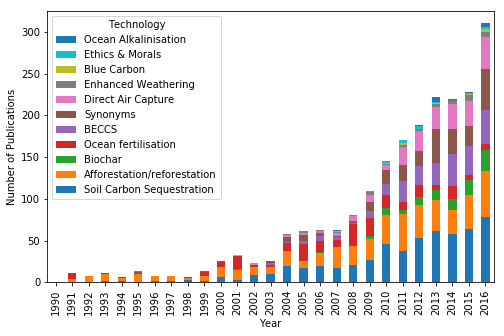

In [81]:
plt.rcParams["figure.figsize"] = [8,5]

pdf = df.pivot(
    index='PY',
    columns='Technology',
    values='n'
)

fig, ax = plt.subplots()


pdf.plot.bar(stacked=True, ax=ax,legend=False)

handles, labels = ax.get_legend_handles_labels()
#lpos = (0.85,2.5)


ax.legend(handles[::-1], labels[::-1],title='Technology')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications')

plt.savefig('plots/general/by_tech.png',bbox_inches='tight') 

plt.show()



In [74]:
tsums = []

for name, group in df.groupby('Technology'):
    gsum = group['n'].sum()
    try:
        g11 = int(group[group['PY']==2011]['n'])
    except:
        g11 = 0
    try:
        g16 = int(group[group['PY']==2016]['n'])
    except:
        g16 = 0
    growth = g16 - g11
    try:
        cagr = (math.pow((g16/g11),(1/5))-1)*100
    except:
        cagr = np.NaN
    tsum = {
        'Technology': name,
        'Sum': gsum,
        '5year_compound_annual_growth_16': cagr 
    }
    tsums.append(tsum)
    
tsummary = pd.DataFrame.from_dict(tsums)

tsummary = tsummary[tsummary['Sum']>0].sort_values('Sum',ascending=False)

tsummary.to_excel('tables/tech_totals.xlsx')

tsummary.head(15)



,5year_compound_annual_growth_16,Sum,Technology
0,19.643850,535,Soil Carbon Sequestration
1,4.563955,487,Afforestation/reforestation
5,21.350978,231,Synonyms
4,9.856054,224,BECCS
3,-2.328132,218,Ocean fertilisation
6,11.550670,205,Direct Air Capture
2,37.972966,97,Biochar
7,14.869835,39,Enhanced Weathering
11,NaN,20,Ocean Alkalinisation
10,0.000000,15,Ethics & Morals


In [75]:
df.to_excel('tables/tech_year_totals.xlsx')